In [2]:
import pandas as pd

df = pd.read_csv('creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print("Class Distribution:\n", df['Class'].value_counts())

Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
492/284315

0.0017304750013189597

Fraud Transactions: 492
Normal Transactions: 284315

--- Fraud Amount Stats ---
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

--- Normal Amount Stats ---
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


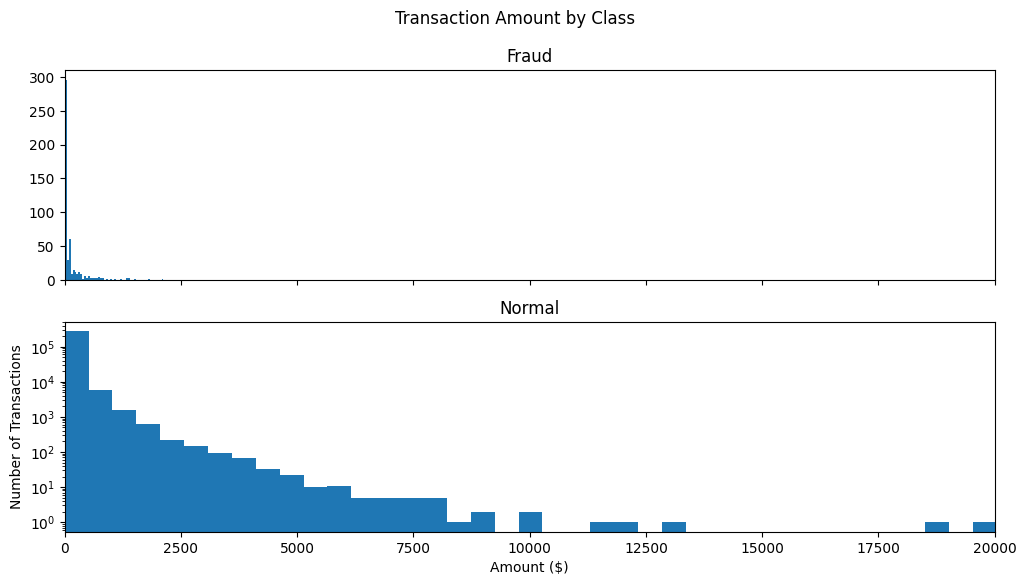

In [5]:
import matplotlib.pyplot as plt

# Separate the data into Fraud and Normal
fraud = df[df['Class'] == 1]
normal = df[df['Class'] == 0]

print(f"Fraud Transactions: {len(fraud)}")
print(f"Normal Transactions: {len(normal)}")

# Let's look at the statistics of the Money involved
print("\n--- Fraud Amount Stats ---")
print(fraud['Amount'].describe())

print("\n--- Normal Amount Stats ---")
print(normal['Amount'].describe())

# Visualizing the difference
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
f.suptitle('Transaction Amount by Class')

bins = 50

ax1.hist(fraud['Amount'], bins=bins)
ax1.set_title('Fraud')

ax2.hist(normal['Amount'], bins=bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log') # We use Log scale because normal counts are huge
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler

# 1. Scale the 'Amount' column
# We create a new column 'scaled_amount'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time', 'Amount'], axis=1) # Drop original unscaled columns

# 2. Define the Under-Sampling Logic
# Get all fraud indices
fraud_indices = df[df['Class'] == 1].index

# Get random normal indices to match the number of frauds
normal_indices = df[df['Class'] == 0].sample(n=len(fraud_indices), random_state=42).index

# 3. Combine them
balanced_indices = fraud_indices.union(normal_indices)
new_df = df.loc[balanced_indices]

# 4. Shuffle the new dataset (so fraud isn't all at the top)
new_df = new_df.sample(frac=1, random_state=42)

print(f"Old Shape: {df.shape}")
print(f"New Shape: {new_df.shape}")
print("\nNew Class Distribution:")
print(new_df['Class'].value_counts())

Old Shape: (284807, 30)
New Shape: (984, 30)

New Class Distribution:
Class
0    492
1    492
Name: count, dtype: int64


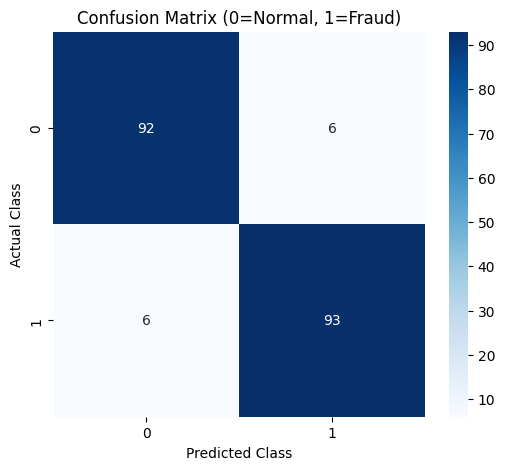

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        98
           1       0.94      0.94      0.94        99

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



In [8]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Split the BALANCED data
X = new_df.drop('Class', axis=1)
y = new_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# 3. Predict
predictions = model.predict(X_test)

# 4. Evaluate using a heatmap
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # fmt='d' means 'digits' (integers)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix (0=Normal, 1=Fraud)')
plt.show()

# 5. Print the detailed report
print(classification_report(y_test, predictions))

In [9]:
from sklearn.ensemble import RandomForestClassifier
# Train a Random Forest Classifier on the balanced dataset
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Classifier Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        98
           1       0.94      0.92      0.93        99

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



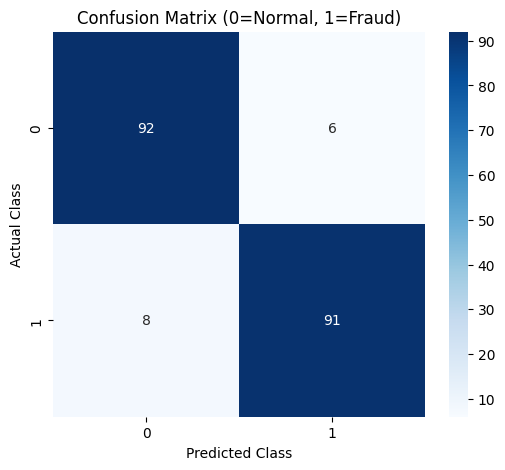

In [10]:
cm = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # fmt='d' means 'digits' (integers)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix (0=Normal, 1=Fraud)')
plt.show()